In [9]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [70]:
# import particles 
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Input, Lambda, Layer, Dropout
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pickle

# Build model

In [13]:
input_dim = 2
latent_dim = 512
output_dim = 2

class MyDropout(Layer):
    def __init__(self, name, latent_dim=latent_dim):
        super().__init__(name=name)
        self.mask = tf.Variable(np.ones(latent_dim), dtype='float32', trainable=False)
    def call(self, inputs):
        return inputs * self.mask
    def update(self, mask):
        assert mask.shape == self.mask.shape, f"new mask shape should be {self.mask.shape} but given {mask.shape}"
        self.mask = tf.Variable(mask)
        self.mask.assign(mask)
    def get(self):
        return self.mask.numpy()
    # may integrate SMC in the future

In [84]:
class MyModel(Model):
    def __init__(self, name):
        super(MyModel, self).__init__(name=name)
        # kaiming init with relu activation
        self.initializer = tf.keras.initializers.HeNormal(seed=42)
        self.dense1 = Dense(latent_dim, activation='relu', name='dense_1')
        self.dense2 = Dense(latent_dim, activation='relu', name='dense_2', kernel_initializer=self.initializer)
        self.dense3 = Dense(output_dim, name='dense_3', kernel_initializer=self.initializer)
        # dropout for gradient descent
        self.dropout_gd = Dropout(rate=0.5, name='dropout_gd')
        # dropout for smc
        self.dropout_smc = MyDropout(latent_dim=latent_dim, name='dropout_smc')
        # flag if dropout in usual nn sense
        self.smc = False

    def call(self, inputs):
        x = self.dense1(inputs)
        if self.smc:
            x = self.dropout_smc(x)
        else:
            x = self.dropout_gd(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

    def update_dropout_mask(self, mask):
        self.dropout.update(mask)

    def get_dropout_mask(self):
        return self.dropout.get()

    def train_smc(self, flag: bool):
        self.smc = flag
        self.dropout_status()

    def dropout_status(self):
        print(f"{'smc' if self.smc else 'normal'} dropout")

    # override summary due to https://stackoverflow.com/questions/55235212/model-summary-cant-print-output-shape-while-using-subclass-model
    def summary(self):
        x = Input(shape=(2), name='input')
        model = Model(inputs=[x], outputs=self.call(x), name=self.name)
        return model.summary()


model = MyModel('Two-Link-Arm')

In [85]:
model.summary()

Model: "Two-Link-Arm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536      
                                                                 
 dropout_gd (Dropout)        (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 265,218
Trainable params: 265,218
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())

# pretraining

In [40]:
loaded = np.load('./two_link_arm_pretraining_data.npz')
# print(np.array_equal(angles , loaded['x']))
# print(np.array_equal(positions , loaded['y']))
angles = loaded['x']
positions = loaded['y']

In [71]:
def step_decay(epoch):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [87]:
# multitask
history = model.fit(angles, positions, epochs=100, batch_size=128, shuffle=True, callbacks=lrate)
model.save('./two_link_arm_pretrained_M.model')
with open('./two_link_arm_pretrained_M.history','wb') as f:
    pickle.dump(history.history, f)

Epoch 1/100
1172/1172 [==============================] - 11s 9ms/step - loss: 0.8476 - lr: 0.0010
Epoch 2/100
1172/1172 [==============================] - 12s 10ms/step - loss: 0.5020 - lr: 0.0010
Epoch 3/100
1172/1172 [==============================] - 12s 10ms/step - loss: 0.4413 - lr: 0.0010
Epoch 4/100
1172/1172 [==============================] - 11s 10ms/step - loss: 0.4146 - lr: 0.0010
Epoch 5/100
1172/1172 [==============================] - 11s 10ms/step - loss: 0.4009 - lr: 0.0010
Epoch 6/100
1172/1172 [==============================] - 12s 10ms/step - loss: 0.3918 - lr: 0.0010
Epoch 7/100
1172/1172 [==============================] - 12s 10ms/step - loss: 0.3852 - lr: 0.0010
Epoch 8/100
1172/1172 [==============================] - 11s 10ms/step - loss: 0.3799 - lr: 0.0010
Epoch 9/100
1172/1172 [==============================] - 12s 10ms/step - loss: 0.3754 - lr: 0.0010
Epoch 10/100
1172/1172 [==============================] - 12s 10ms/step - loss: 0.3605 - lr: 5.0000e-04
Epoch 

In [88]:
loss = history.history['loss']

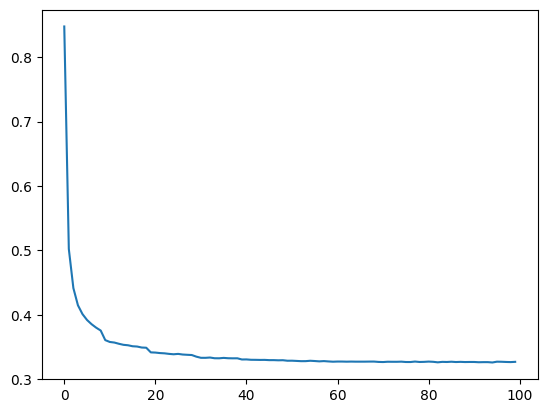

In [89]:
plt.plot(loss)

In [90]:
pretrained = tf.keras.models.load_model('two_link_arm_pretrained_M.model')